In [1]:
import pandas as pd
import sqlite3

In [98]:
excel_file = "ONJ_samples.xlsx"
db_file = "ONJ.db"

# Load Excel files (df is the main dataset, and Medications and Genetics will be joined later
df = pd.read_excel(excel_file, sheet_name='Demographics')
medi = pd.read_excel(excel_file, sheet_name='Medications')
gene = pd.read_excel(excel_file, sheet_name='Genetics')

# Clean column names to be SQL-friendly
df.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in df.columns]
medi.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in medi.columns]
gene.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in gene.columns]

# Create SQLite DB 
conn = sqlite3.connect(db_file)
df.to_sql("ONJ", conn, if_exists="replace", index=False)
medi.to_sql("medi", conn, if_exists="replace", index=False)
gene.to_sql("gene", conn, if_exists="replace", index=False)

conn.close()
print(f"Database '{db_file}' created with table 'ONJ'")

# Helper function to connect
def connect_db(db_file=db_file):
    """Connect to the SQLite DB and return connection."""
    return sqlite3.connect(db_file)

# Helper function to run queries
def run_query(query, db_file=db_file):
    """Run a SQL query and return a pandas DataFrame."""
    conn = connect_db(db_file)
    result = pd.read_sql_query(query, conn)
    conn.close()
    return result

# Test queries
row_count = run_query("SELECT COUNT(*) AS n_rows FROM ONJ;")
print("Number of rows:", row_count['n_rows'][0])

preview = run_query("SELECT * FROM ONJ LIMIT 5;")
display(preview)

Database 'ONJ.db' created with table 'ONJ'
Number of rows: 46


,Sample_ID,age,gender,race,ethnic,cancer_type,ONJ
0,ONJ1,33,male,white,non hispanic,myeloma,Yes
1,ONJ2,51,female,white,non hispanic,breast,Yes
2,ONJ3,52,female,white,non hispanic,breast,Yes
3,ONJ4,55,female,white,non hispanic,breast,Yes
4,ONJ5,55,female,white,non hispanic,breast,Yes


In [103]:
with connect_db() as conn:
    conn.execute("""
        CREATE TABLE IF NOT EXISTS ONJ_j AS
SELECT 
    ONJ.Sample_ID,
    ONJ.age,
    ONJ.gender,
    ONJ.race,
    ONJ.ethnic,
    ONJ.cancer_type,
    ONJ.ONJ,
    medi.Summary_of_BP,
    medi.Route,
    medi.Months,
    gene.SNP1,
    gene.SNP2
FROM ONJ
JOIN medi ON ONJ.Sample_ID = medi.Sample_ID
JOIN gene ON ONJ.Sample_ID = gene.Sample_ID;
""")


In [104]:
run_query("""
PRAGMA table_info(ONJ_j);
""")

,cid,name,type,notnull,dflt_value,pk
0,0,Sample_ID,TEXT,0,None,0
1,1,age,INT,0,None,0
2,2,gender,TEXT,0,None,0
3,3,race,TEXT,0,None,0
4,4,ethnic,TEXT,0,None,0
5,5,cancer_type,TEXT,0,None,0
6,6,ONJ,TEXT,0,None,0
7,7,Summary_of_BP,TEXT,0,None,0
8,8,Route,TEXT,0,None,0
9,9,Months,INT,0,None,0


In [ ]:
# Find the number of patients participating in the study

In [110]:
df = run_query("""
SELECT COUNT(Sample_ID),ONJ 
FROM ONJ_j
GROUP BY ONJ;
""")
print("Number of patients participating in the study:\n",df)

Number of patients participating in the study:
    COUNT(Sample_ID)  ONJ
0                23   No
1                23  Yes


In [ ]:
# Find the distribution of cancer types

In [108]:
df = run_query("""
SELECT cancer_type, COUNT(Sample_ID),ONJ 
FROM ONJ_j
GROUP BY cancer_type,ONJ
ORDER BY cancer_type,ONJ
""")
print("The distribution of cancer types:\n",df)

The distribution of cancer types:
   cancer_type  COUNT(Sample_ID)  ONJ
0      breast                 1   No
1      breast                 7  Yes
2        lung                 8   No
3        lung                 3  Yes
4     myeloma                 9   No
5     myeloma                 9  Yes
6    prostate                 5   No
7    prostate                 4  Yes


In [ ]:
# Find the distribution of medications

In [111]:
df1 = run_query("""
SELECT Summary_of_BP AS drug, COUNT(Sample_ID),ONJ 
FROM ONJ_j
GROUP BY ONJ, Summary_of_BP
ORDER BY ONJ, Summary_of_BP;
""")
print("The distribution of cancer types:\n",df1)

The distribution of cancer types:
           drug  COUNT(Sample_ID)  ONJ
0  Pamidronate                 7   No
1  Zoledronate                16   No
2  Alendronate                12  Yes
3  Pamidronate                 3  Yes
4  Zoledronate                 8  Yes


In [ ]:
# Find gender distribution

In [112]:
df1 = run_query("""
SELECT gender, COUNT(gender),ONJ 
FROM ONJ_j
GROUP BY gender,ONJ;
""")
print("Gender distribution:\n",df1)

Gender distribution:
    gender  COUNT(gender)  ONJ
0  female             11   No
1  female             11  Yes
2    male             12   No
3    male             12  Yes


In [ ]:
# Find the mean age 

In [114]:
df1 = run_query("""
SELECT ONJ, ROUND(
AVG(age),1) AS Mean 
FROM ONJ_j
GROUP BY ONJ;
""")
print("The mean age is:\n",df1)

The mean age is:
    ONJ  Mean
0   No  61.6
1  Yes  63.6


In [ ]:
# Find the mean duration of bisphosphonate usage 

In [115]:
df1 = run_query("""
SELECT ONJ, ROUND(
AVG(Months),1) AS Mean
FROM ONJ_j
GROUP BY ONJ;
""")
print("Mean duration of bisphosphonate usage:\n",df1)

Mean duration of bisphosphonate usage:
    ONJ  Mean
0   No  50.9
1  Yes  32.2


In [ ]:
# Find the mean duration of bisphosphonate usage by bisphosphonate type

In [119]:
df1 = run_query("""
SELECT Summary_of_BP AS Bisphosphonate_type, ONJ, 
ROUND(
AVG(Months),1) AS Mean
FROM ONJ_j
GROUP BY ONJ, Summary_of_BP
ORDER BY ONJ, Summary_of_BP ;
""")
print("Mean duration of bisphosphonate usage per drug:\n",df1)

Mean duration of bisphosphonate usage per drug:
   Bisphosphonate_type  ONJ  Mean
0         Pamidronate   No  67.6
1         Zoledronate   No  43.6
2         Alendronate  Yes  39.3
3         Pamidronate  Yes  15.0
4         Zoledronate  Yes  27.9


In [ ]:
# Find the mean duration of bisphosphonate usage by cancer type

In [121]:
df1 = run_query("""
SELECT cancer_type, ONJ, 
ROUND(
AVG(Months),1) AS Mean
FROM ONJ_j
GROUP BY ONJ, cancer_type
ORDER BY ONJ, cancer_type ;
""")
print("Mean duration of bisphosphonate usage per cancer type:\n",df1)

Mean duration of bisphosphonate usage per cancer type:
   cancer_type  ONJ  Mean
0      breast   No  27.0
1        lung   No  51.1
2     myeloma   No  55.3
3    prostate   No  47.2
4      breast  Yes  41.3
5        lung  Yes  18.7
6     myeloma  Yes  36.2
7    prostate  Yes  17.3


In [ ]:
# Find distribution of SNP1 and 2 among patient/controls

In [123]:
df1 = run_query("""
SELECT SNP1, COUNT(SNP1), ONJ
FROM ONJ_j
GROUP BY ONJ, SNP1
ORDER BY ONJ, SNP1 ;
""")
print("distribution of SNP1 among patient/controls:\n",df1)

distribution of SNP1 among patient/controls:
   SNP1  COUNT(SNP1)  ONJ
0   No           20   No
1  Yes            3   No
2   No           13  Yes
3  Yes           10  Yes


In [132]:
df1 = run_query("""
SELECT SNP2, COUNT(SNP2), ONJ
FROM ONJ_j
GROUP BY ONJ, SNP2
ORDER BY ONJ, SNP2 ;
""")
print("distribution of SNP2 among patient/controls:\n",df1)

distribution of SNP2 among patient/controls:
   SNP2  COUNT(SNP2)  ONJ
0   No           22   No
1  Yes            1   No
2   No           19  Yes
3  Yes            4  Yes


In [ ]:
# Calculate OR of SNP1, by using the Common Table Expression counts:

In [130]:
df1 = run_query("""
WITH counts AS (
    SELECT
        SUM(CASE WHEN SNP1 = 'Yes' AND ONJ = 'Yes' THEN 1 ELSE 0 END) AS a,
        SUM(CASE WHEN SNP1 = 'Yes' AND ONJ = 'No'  THEN 1 ELSE 0 END) AS b,
        SUM(CASE WHEN SNP1 = 'No'  AND ONJ = 'Yes' THEN 1 ELSE 0 END) AS c,
        SUM(CASE WHEN SNP1 = 'No'  AND ONJ = 'No'  THEN 1 ELSE 0 END) AS d
    FROM ONJ_joined
)
SELECT 
    a, b, c, d,
    ROUND((a * d * 1.0) / (b * c), 2) AS Odd_Ratio
FROM counts;
""")
print("Odd Ratio of SNP1 is:\n",df1)

Odd Ratio of SNP1 is:
     a  b   c   d  Odd_Ratio
0  10  3  13  20       5.13


In [ ]:
# Calculate OR of SNP2, by using the Common Table Expression counts:

In [133]:
df1 = run_query("""
WITH counts AS (
    SELECT
        SUM(CASE WHEN SNP2 = 'Yes' AND ONJ = 'Yes' THEN 1 ELSE 0 END) AS a,
        SUM(CASE WHEN SNP2 = 'Yes' AND ONJ = 'No'  THEN 1 ELSE 0 END) AS b,
        SUM(CASE WHEN SNP2 = 'No'  AND ONJ = 'Yes' THEN 1 ELSE 0 END) AS c,
        SUM(CASE WHEN SNP2 = 'No'  AND ONJ = 'No'  THEN 1 ELSE 0 END) AS d
    FROM ONJ_joined
)
SELECT 
    a, b, c, d,
    ROUND((a * d * 1.0) / (b * c), 2) AS Odd_Ratio
FROM counts;
""")
print("Odd Ratio of SNP2 is:\n",df1)

Odd Ratio of SNP2 is:
    a  b   c   d  Odd_Ratio
0  4  1  19  22       4.63


In [ ]:
# switching to python for analysis and visualization

In [137]:
# Load ONJ_j table into a pandas DataFrame
df_onj = run_query("SELECT * FROM ONJ_j;")

# Preview the first rows
print(df_onj.head())


  Sample_ID  age  gender   race        ethnic cancer_type  ONJ Summary_of_BP  \
0      ONJ1   33    male  white  non hispanic     myeloma  Yes   Alendronate   
1      ONJ2   51  female  white  non hispanic      breast  Yes   Alendronate   
2      ONJ3   52  female  white  non hispanic      breast  Yes   Alendronate   
3      ONJ4   55  female  white  non hispanic      breast  Yes   Alendronate   
4      ONJ5   55  female  white  non hispanic      breast  Yes   Alendronate   

  Route  Months SNP1 SNP2  
0  Oral      87  Yes   No  
1  Oral      46  Yes   No  
2  Oral      13  Yes   No  
3  Oral      30   No  Yes  
4  Oral      55   No   No  


In [ ]:
# cancer type vs ONJ 

In [185]:
# Cross tabulation between ONJ and SNP1
CrosstabResult = pd.crosstab(index=df_onj['ONJ'],columns=df_onj['cancer_type'])
print(CrosstabResult)

cancer_type  breast  lung  myeloma  prostate
ONJ                                         
No                1     8        9         5
Yes               7     3        9         4


In [186]:
from scipy.stats import chi2_contingency

# Performing Chi-square test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', round(ChiSqResult[1],3))

The P-Value of the ChiSq Test is: 0.076


In [ ]:
# SNP1 vs ONJ 

In [178]:
# Cross tabulation between ONJ and SNP1
CrosstabResult = pd.crosstab(index=df_onj['ONJ'],columns=df_onj['SNP1'])
print(CrosstabResult)

SNP1  No  Yes
ONJ          
No    20    3
Yes   13   10


In [180]:
# Performing Chi-square test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', round(ChiSqResult[1],3))

The P-Value of the ChiSq Test is: 0.049


In [ ]:
# SNP2 vs ONJ 

In [181]:
# Cross tabulation between ONJ and SNP1
CrosstabResult = pd.crosstab(index=df_onj['ONJ'],columns=df_onj['SNP2'])
print(CrosstabResult)

SNP2  No  Yes
ONJ          
No    22    1
Yes   19    4


In [182]:
# Performing Chi-square test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', round(ChiSqResult[1],3))

The P-Value of the ChiSq Test is: 0.343


In [ ]:
# ONJ vs SNP1 OR SNP2

In [183]:
import numpy as np

df_onj["SNP_any"] = np.where(
    (df_onj["SNP1"] == "Yes") | (df_onj["SNP2"] == "Yes"),
    "Yes", "No"
)
# Cross tabulation between ONJ and SNP1
CrosstabResult = pd.crosstab(index=df_onj['ONJ'],columns=df_onj['SNP_any'])
print(CrosstabResult)
# Performing Chi-square test
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', round(ChiSqResult[1],3))

SNP_any  No  Yes
ONJ             
No       19    4
Yes      10   13
The P-Value of the ChiSq Test is: 0.015


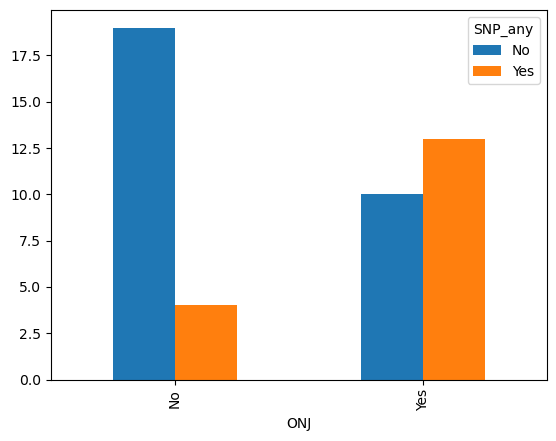

In [184]:
CrosstabResult.plot.bar();

In [193]:
from scipy.stats import ttest_ind
# Age comparison (t-test)
age_onj = df_onj.loc[df_onj['ONJ']=='Yes', 'age']
age_ctrl = df_onj.loc[df_onj['ONJ']=='No', 'age']
t_stat, p_val = ttest_ind(age_onj, age_ctrl)
print("t-test Age ONJ vs Control:", p_val)

t-test Age ONJ vs Control: 0.4860478283210089
